In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fashionmnist/t10k-labels-idx1-ubyte
/kaggle/input/fashionmnist/t10k-images-idx3-ubyte
/kaggle/input/fashionmnist/fashion-mnist_test.csv
/kaggle/input/fashionmnist/fashion-mnist_train.csv
/kaggle/input/fashionmnist/train-labels-idx1-ubyte
/kaggle/input/fashionmnist/train-images-idx3-ubyte


In [2]:
!nvidia-smi

Wed Nov 19 16:25:46 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   36C    P8              9W /   70W |       1MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## Building ANN on Fashion MNIST Dataset

In [3]:
import pandas as pd

from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [4]:
torch.manual_seed(42)

In [5]:
df = pd.read_csv(r"/kaggle/input/fashionmnist/fashion-mnist_train.csv")
df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
print(df.shape)

(60000, 785)


In [8]:
train_df = df # alternate name for df 

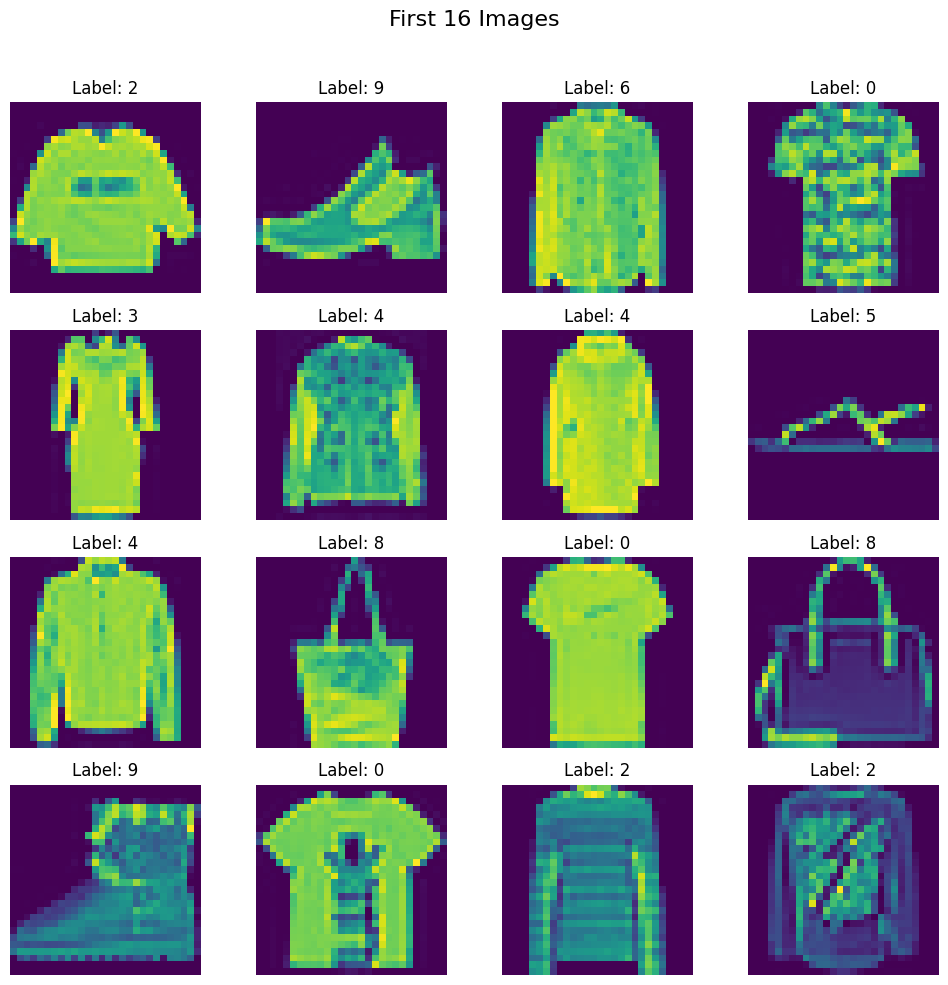

In [9]:
# visualizing first few images

fig, axes = plt.subplots(4, 4, figsize=(10, 10))
fig.suptitle("First 16 Images", fontsize=16)

for i, ax in enumerate(axes.flat):
    img = df.iloc[i, 1:].values.reshape(28, 28) # reshape to 28 x 28
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(f"Label: {df.iloc[i, 0]}")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [10]:
train_df["label"].value_counts()

label
2    6000
9    6000
6    6000
0    6000
3    6000
4    6000
5    6000
8    6000
7    6000
1    6000
Name: count, dtype: int64

In [19]:
X = train_df.drop(columns=["label"])
y = train_df[["label"]]

In [22]:
# scaling the feature
# 0 - 255 -> 0 to 1
X = X / 255.0

In [24]:
# custom dataset class

class CustomDataset(Dataset):
    def __init__(self, features, target) -> None:
        self.features = torch.tensor(features.values, dtype=torch.float32)
        self.target = torch.tensor(target.values, dtype=torch.long)
    
    def __len__(self) -> int:
        return len(self.features)

    def __getitem__(self, index):
        return self.features[index], self.target[index]

In [25]:
train_data = CustomDataset(X, y)

In [26]:
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)

In [34]:
if torch.cuda.is_available():
    print(torch.cuda.get_device_name())
    device = torch.device('cuda')

Tesla T4


In [35]:
# defining NN class

class FashionMNISTNN(nn.Module):
    def __init__(self, n_features) -> None:
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(n_features, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(64, 10),
            # nn.Softmax() #  In Cross Entropy Loss - softmax implemented by default in PyTorch
        )

    def forward(self, x):

        return self.model(x)

In [48]:
learning_rate = 0.01
epochs = 100

In [49]:
model = FashionMNISTNN(X.shape[1])

# using GPU
model.to(device)

FashionMNISTNN(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.3, inplace=False)
    (8): Linear(in_features=64, out_features=10, bias=True)
  )
)

In [50]:
# loss function
criterion = nn.CrossEntropyLoss()

# optimizer
optimizer = optim.SGD(
    model.parameters(), 
    lr=learning_rate,
    weight_decay=1e-4 # regularization term
)


In [51]:
%%time
# training loop

for epoch in range(epochs):
    total_epoch_loss = 0
    for batch_features, batch_targets in train_loader:

        # Moving batch_features and batch_labels on GPU
        batch_features = batch_features.to(device)
        batch_targets = batch_targets.to(device)
        
        # forward pass
        out = model(batch_features)

        # calculate loss
        batch_targets = batch_targets.squeeze(1).long() 
        loss = criterion(out, batch_targets)

        # backpass 
        optimizer.zero_grad()
        loss.backward()
        total_epoch_loss += loss.item()

        # update gradient
        optimizer.step()
    
    # printing average epoch loss
    print(f"Epoch {epoch + 1}/{epochs} - Loss: {total_epoch_loss/len(train_loader)}")

Epoch 1/100 - Loss: 0.7595066247622172
Epoch 2/100 - Loss: 0.5378499782085419
Epoch 3/100 - Loss: 0.49348862759272255
Epoch 4/100 - Loss: 0.46792463200887047
Epoch 5/100 - Loss: 0.4481363744854927
Epoch 6/100 - Loss: 0.43372863671382267
Epoch 7/100 - Loss: 0.42094001694917677
Epoch 8/100 - Loss: 0.4105312323053678
Epoch 9/100 - Loss: 0.40293136077721914
Epoch 10/100 - Loss: 0.39093178188006084
Epoch 11/100 - Loss: 0.38653689231475197
Epoch 12/100 - Loss: 0.37739748151699704
Epoch 13/100 - Loss: 0.37420793723662693
Epoch 14/100 - Loss: 0.36804630447626113
Epoch 15/100 - Loss: 0.36200235067605974
Epoch 16/100 - Loss: 0.3573157845298449
Epoch 17/100 - Loss: 0.3546419395685196
Epoch 18/100 - Loss: 0.34737438907225926
Epoch 19/100 - Loss: 0.3443791935165723
Epoch 20/100 - Loss: 0.3396719537059466
Epoch 21/100 - Loss: 0.33908453942139943
Epoch 22/100 - Loss: 0.3337911107401053
Epoch 23/100 - Loss: 0.3317485396941503
Epoch 24/100 - Loss: 0.332005640900135
Epoch 25/100 - Loss: 0.32590526851813

#### Evaluations

In [52]:
test_df = pd.read_csv("/kaggle/input/fashionmnist/fashion-mnist_test.csv")

In [53]:
X_test = test_df.drop(columns=["label"])
y_test = test_df["label"]

In [55]:
X_test = X_test / 255.0

In [58]:
test_data = CustomDataset(X_test, y_test)
test_loader = DataLoader(test_data, batch_size=32, shuffle=True)

In [59]:
# need to tell model that it is being evaluated
# need as different behaviour during training and prediction
model.eval()

FashionMNISTNN(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.3, inplace=False)
    (8): Linear(in_features=64, out_features=10, bias=True)
  )
)

In [61]:
total = 0
correct = 0

# no gradient calculation while training
with torch.no_grad():
    for batch_features, batch_targets in test_loader:
        # Moving batch_features and batch_labels on GPU
        batch_features = batch_features.to(device)
        batch_targets = batch_targets.to(device)

        
        out = model(batch_features)

        _, predicted = torch.max(out, 1)

        total = total + batch_targets.shape[0]
        correct = correct + (predicted == batch_targets).sum().item()

print(f"Accuracy: {correct/total}")

Accuracy: 0.9026


In [ ]:
import torch
import torch.nn as nn # For the loss function
from tqdm import tqdm # For the progress bar
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_model(model, test_loader, class_names):
    """
    Evaluates the performance of a PyTorch model on a test dataset.

    Args:
        model (nn.Module): The trained PyTorch model.
        test_loader (DataLoader): DataLoader for the test dataset.
        class_names (list): List of class names for the classification report.
    """
    # 1. Device Setup
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval() # Set the model to evaluation mode
    criterion = nn.CrossEntropyLoss()

    total_loss = 0.0
    total_correct = 0
    total_samples = 0
    
    # Lists to store all predictions and true labels for detailed metrics
    all_predictions = []
    all_targets = []

    # 2. Evaluation Loop
    with torch.no_grad(): # Disable gradient calculations
        # Add tqdm for a progress bar during evaluation
        for batch_features, batch_targets in tqdm(test_loader, desc="Evaluating"):
            
            # Insert this logic inside the evaluation loop:
            if batch_targets.dim() > 1 and batch_targets.size(1) > 1:
                # Converts one-hot targets back to class indices for CrossEntropyLoss
                batch_targets = torch.argmax(batch_targets, dim=1)
            # Move data to the appropriate device
            batch_features = batch_features.to(device)
            batch_targets = batch_targets.to(device)


            # Forward pass
            out = model(batch_features)
            
            # Calculate Loss
            loss = criterion(out, batch_targets)
            total_loss += loss.item() * batch_features.size(0) # Accumulate loss

            # Get predicted class (index with the highest probability)
            _, predicted = torch.max(out, 1)

            # Update accuracy metrics
            total_samples += batch_targets.size(0)
            total_correct += (predicted == batch_targets).sum().item()
            
            # Store predictions and targets for scikit-learn metrics
            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(batch_targets.cpu().numpy())

    # 3. Calculate Final Metrics
    avg_loss = total_loss / total_samples
    accuracy = total_correct / total_samples

    print("\n" + "="*50)
    print("## ✨ Final Performance Metrics")
    print(f"Test Loss: {avg_loss:.4f}")
    print(f"Test Accuracy: {accuracy:.4f} ({total_correct}/{total_samples})")
    print("="*50 + "\n")

    # 4. Generate Classification Report
    print("## 📋 Classification Report")
    print(classification_report(all_targets, all_predictions, target_names=class_names, digits=4))

    # 5. Visualize Confusion Matrix
    print("## 🖼️ Confusion Matrix")
    # 
    cm = confusion_matrix(all_targets, all_predictions)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        cm, 
        annot=True, 
        fmt='d', 
        cmap='Blues', 
        xticklabels=class_names, 
        yticklabels=class_names
    )
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()


In [69]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", 
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

Evaluating: 100%|██████████| 313/313 [00:00<00:00, 814.54it/s]



## ✨ Final Performance Metrics
Test Loss: 0.2877
Test Accuracy: 0.9026 (9026/10000)

## 📋 Classification Report
              precision    recall  f1-score   support

 T-shirt/top     0.8316    0.8590    0.8451      1000
     Trouser     0.9840    0.9840    0.9840      1000
    Pullover     0.8561    0.8210    0.8382      1000
       Dress     0.9020    0.9200    0.9109      1000
        Coat     0.8216    0.8980    0.8581      1000
      Sandal     0.9785    0.9550    0.9666      1000
       Shirt     0.7752    0.7000    0.7357      1000
     Sneaker     0.9398    0.9520    0.9459      1000
         Bag     0.9819    0.9740    0.9779      1000
  Ankle boot     0.9525    0.9630    0.9577      1000

    accuracy                         0.9026     10000
   macro avg     0.9023    0.9026    0.9020     10000
weighted avg     0.9023    0.9026    0.9020     10000

## 🖼️ Confusion Matrix


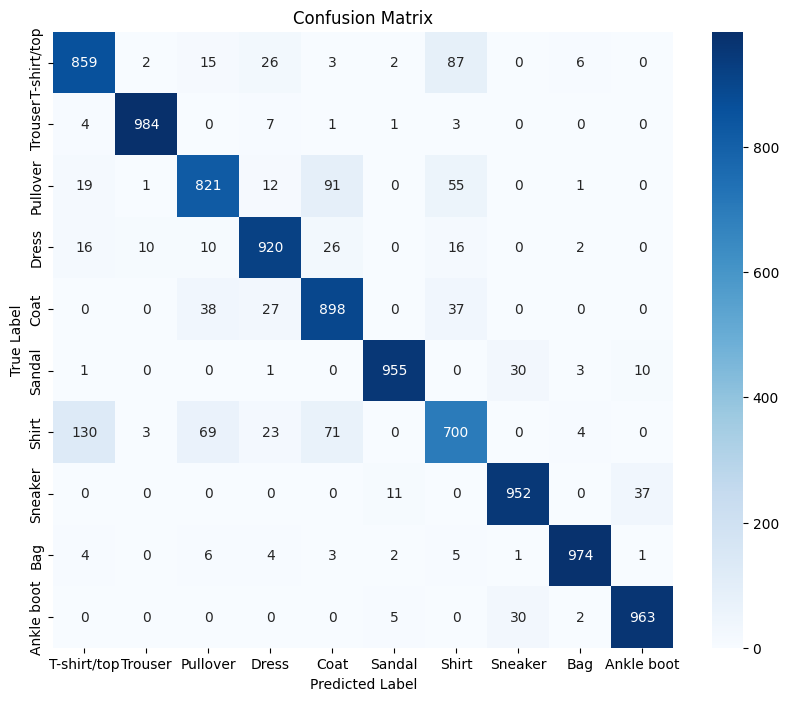

In [70]:
evaluate_model(model, test_loader, class_names)